In [100]:
import requests
from pathlib import Path
import io
import zipfile
import os
import pandas as pd
import shutil
from pydantic import BaseModel
from typing import Dict, List, Optional, Any
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
from PIL import Image
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [101]:
flicker_dir = Path("../data/flicker")
augmented_dir = Path("../data/augmented")

flicker_dir.mkdir(parents=True, exist_ok=True)
augmented_dir.mkdir(parents=True, exist_ok=True)

In [102]:
# '''Get dataset from flicker'''
# url = "https://www.lirmm.fr/~poncelet/Ressources/flickr_subset2.zip"
# print("Requesting...\n")
# response = requests.get(url)
# if response.status_code == 200:
#     print("Téléchargement réussi. Extraction...")
#     with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
#         # Extraire sans ajouter de sous-dossier supplémentaire
#         for member in zip_ref.namelist():
#             # Corrige les chemins pour ignorer un éventuel prefixe flickr_subset2/
#             member_path = member
#             if member.startswith("flickr_subset2/"):
#                 member_path = member[len("flickr_subset2/"):]
#             target_path = flicker_dir / member_path

#             # Si c'est un répertoire, on le crée
#             if member.endswith("/"):
#                 target_path.mkdir(exist_ok=True, parents=True)
#             else:
#                 os.makedirs(os.path.dirname(target_path), exist_ok=True)
#                 with zip_ref.open(member) as source, open(target_path, "wb") as target:
#                     target.write(source.read())
#     print(f"Données extraites dans : {flicker_dir}")
# else:
#     print("Échec du téléchargement. Code HTTP :", response.status_code)


In [103]:
!ls ..

README.md  data  main.py  notebooks  pyproject.toml  uv.lock


In [ ]:
metadata_path = Path("../data/augmented/metadata.csv")
df = pd.read_csv(metadata_path)
print(df.columns)
print(df.iloc[0])

In [ ]:
def get_label(filename: str):
    return filename.split("_")[0]


def get_uuid(filename: str):
    name = Path(filename).stem          
    parts = name.split("_")
    return "_".join(parts[:2])          


def build_augmented_path(img_path: Path, base_dir: Path):
    img_path = Path(img_path)
    filename = img_path.name
    label = get_label(filename)
    uuid = get_uuid(filename)
    print(uuid)

    return base_dir / label / uuid / filename

get_label(df["image_path"].iloc[1])
get_uuid(df["image_path"].iloc[1])

print(build_augmented_path(df["image_path"].iloc[1], augmented_dir))

In [ ]:

transform = transforms.Compose(
    [transforms.Resize((300, 500)),
        transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class ImageCLIPDataset(Dataset):
    def __init__(self, imgs, labels, base_dir: Path, transform):
        self.img_paths = [Path(build_augmented_path(img, base_dir)) for img in imgs]
        self.labels = labels
        self.transform = transform
        self.classes = sorted(set(self.labels))                  
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}  



    def __getitem__(self, idx) -> Tuple[Image.Image, str]:
        img = Image.open(self.img_paths[idx]).convert("RGB")
        label_str = self.labels[idx]
        label = self.class_to_idx[label_str]   

        if self.transform:
            img = self.transform(img)
        return idx, img, label
    
    def __len__(self) -> int:
        return len(self.img_paths)
    
    def _get_img_path_from_idx(self, idx: int) -> Path:
        return self.img_paths[idx]
    
    def _get_label_from_idx(self, idx: int) -> str :
        return self.labels[idx]
    
    def _get_img_size(self, idx: int) -> Tuple[int, int]:
        img = Image.open(self.img_paths[idx]).convert("RGB")
        if self.transform:
            for t in self.transform.transforms:
                if isinstance(t, transforms.Resize):
                    img = t(img)
        return img.height, img.width

    
    
    

        


In [ ]:
X =  df["image_path"]
print(X)

In [ ]:

df_train, df_temp = train_test_split(df, test_size=0.3, random_state=11)
df_test, df_val = train_test_split(df_temp, test_size=0.5, random_state=11)

print(len(df_train), len(df_test), len(df_val))
print(df_train["label"].value_counts(normalize=True) * 100)
print(df_val["label"].value_counts(normalize=True) * 100)
print(df_test["label"].value_counts(normalize=True) * 100)


In [ ]:
X_train, y_train = df_train["image_path"], df_train["label"]
X_val, y_val     = df_val["image_path"], df_val["label"]
X_test, y_test   = df_test["image_path"], df_test["label"]


In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [ ]:
train_dataset = ImageCLIPDataset(X_train, y_train, augmented_dir, transform_resnet)
val_dataset   = ImageCLIPDataset(X_val, y_val, augmented_dir, transform_resnet)
test_dataset  = ImageCLIPDataset(X_test, y_test, augmented_dir, transform_resnet)


In [ ]:
print(train_dataset._get_img_size(3))
print(train_dataset._get_img_size(13))
img = train_dataset._get_img_path_from_idx(3)
lg = Image.open(build_augmented_path(img, augmented_dir))
display(lg)
print(train_dataset.__getitem__(3))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
class CNNBasic(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2,2)
        )

        self.flattened_size = self._get_flattened_size()

        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 300, 500)
            x = self.features(x)
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [ ]:
model = CNNBasic(4)

In [ ]:
model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
print(len(train_dataset))
print(len(test_dataset))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)
EPOCHS = 11

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    loop = tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch+1}/10 [TRAIN]")
    for i, data in loop:
        idx, inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=running_loss/(i+1))

    avg_train_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} - Average TRAIN loss: {avg_train_loss:.4f}")


    model.eval()
    running_test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/10 [EVAL]")
        for idx, inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = running_test_loss / len(test_loader)
    print(f"Epoch {epoch+1} - Average TEST loss: {avg_test_loss:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=3))




In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
num_classes = 4

model_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
model.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # <--- ajoute compatibilité toutes tailles

model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-4, weight_decay=1e-5)



In [ ]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0

    for idx, inputs, labels in tqdm(loader, desc="TRAIN", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


def evaluate(model, loader, name="VALID"):
    model.eval()
    preds, targets = [], []
    running_loss = 0.0

    with torch.no_grad():
        for idx, inputs, labels in tqdm(loader, desc=name, leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = outputs.argmax(dim=1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader)
    print(f"\n{name} loss: {avg_loss:.4f}")
    print(f"{name} classification report:\n",
          classification_report(targets, preds, digits=3))

    return avg_loss


# ============================================
# Training Loop
# ============================================
EPOCHS = 11  # à ajuster
for epoch in range(1, EPOCHS + 1):
    print(f"\n========== Epoch {epoch}/{EPOCHS} ==========")
    train_loss = train_one_epoch(model_resnet, train_loader)
    print(f"Train loss: {train_loss:.4f}")
    evaluate(model_resnet, val_loader)


========== Epoch 1/11 ==========


Train loss: 0.0016



VALID loss: 0.2842
VALID classification report:
               precision    recall  f1-score   support

           0      0.917     0.902     0.909        61
           1      0.937     0.937     0.937        63
           2      0.845     0.899     0.871        79
           3      0.937     0.881     0.908        67

    accuracy                          0.904       270
   macro avg      0.909     0.904     0.906       270
weighted avg      0.905     0.904     0.904       270


========== Epoch 2/11 ==========


KeyboardInterrupt: 

In [130]:
class ResNet18EarlyExit(nn.Module):
    def __init__(self, num_classes=4, threshold=0.9):
        super().__init__()
        self.threshold = threshold

        base = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        self.stem = nn.Sequential(
            base.conv1, base.bn1, base.relu, base.maxpool
        )
        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4
        
        self.exit1 = self._make_exit(64, num_classes)
        self.exit2 = self._make_exit(128, num_classes)
        self.exit3 = self._make_exit(256, num_classes)
        self.exit4 = nn.Linear(base.fc.in_features, num_classes)

    def _make_exit(self, channels, num_classes):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(channels, num_classes)
        )
    def extract_features(self, x):
        features = {}

        x = self.stem(x)
        x = self.layer1(x)
        f1 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit1"] = f1

        x = self.layer2(x)
        f2 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit2"] = f2

        x = self.layer3(x)
        f3 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit3"] = f3

        x = self.layer4(x)
        f4 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit4"] = f4

        return features
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        out1 = self.exit1(x)
        if self._confident(out1):
            return out1
        
        x = self.layer2(x)
        out2 = self.exit2(x)
        if self._confident(out2):
            return out2
        
        x = self.layer3(x)
        out3 = self.exit3(x)
        if self._confident(out3):
            return out3
        
        x = self.layer4(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = torch.flatten(x, 1)
        out4 = self.exit4(x)
        return out4, 4

    def _confident(self, logits):
        probs = logits.softmax(dim=1)
        max_conf = probs.max(dim=1).values
        return (max_conf > self.threshold).any()


In [131]:
model_resnet_custom = ResNet18EarlyExit()
model_resnet_custom = model_resnet_custom.to(device)

In [132]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet_custom.parameters(), lr=1e-4, weight_decay=1e-5)

for epoch in range(5):
    model_resnet_custom.train()
    running_loss = 0.0
    for idx, inputs, labels in tqdm(train_loader, desc=f"TRAIN {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model_resnet_custom(inputs)

        if isinstance(output, tuple):
            logits = output[0]
        else:
            logits = output

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}: Train loss = {running_loss/len(train_loader):.4f}")


TRAIN 1: 100%|██████████| 40/40 [00:07<00:00,  5.21it/s]


Epoch 1: Train loss = 0.7006


TRAIN 2: 100%|██████████| 40/40 [00:07<00:00,  5.22it/s]


Epoch 2: Train loss = 0.1196


TRAIN 3: 100%|██████████| 40/40 [00:07<00:00,  5.10it/s]


Epoch 3: Train loss = 0.0336


TRAIN 4: 100%|██████████| 40/40 [00:07<00:00,  5.27it/s]


Epoch 4: Train loss = 0.0181


TRAIN 5: 100%|██████████| 40/40 [00:07<00:00,  5.28it/s]

Epoch 5: Train loss = 0.0105


In [133]:
def predict_image(model, img_tensor, class_names):
    model.eval()
    with torch.no_grad():
        logits, exit_id = model(img_tensor.unsqueeze(0).to(device))
        probs = logits.softmax(dim=1)
        confidence, pred = torch.max(probs, dim=1)
        return class_names[pred.item()], confidence.item(), exit_id

img, label = val_dataset[0][1], val_dataset[0][2]  

print(val_dataset._get_label_from_idx(0))

class_names = ["Label.BALL", "Label.BIKE", "Label.DOG", "Label.WATER"]

pred, conf, exit_used = predict_image(model_resnet_custom, img, class_names)
print("Prediction:", pred)
print("Confidence:", round(conf, 3))
print("Exit used:", exit_used)


Label.DOG
Prediction: Label.DOG
Confidence: 0.97
Exit used: 4


In [134]:

def evaluate(model, loader, name="VAL"):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    eval_loss = 0.0

    with torch.no_grad():
        for idx, inputs, labels in tqdm(loader, desc=f"{name}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            output = model(inputs)
            if isinstance(output, torch.Tensor):
                print("hello")
                logits = output
            elif isinstance(output, (list, tuple)):
                logits = next((o for o in output if isinstance(o, torch.Tensor)), None)

            logits = output[0] if isinstance(output, tuple) else output

            loss = criterion(logits, labels)
            eval_loss += loss.item()

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = eval_loss / len(loader)
    print(f"\n{name} Loss: {avg_loss:.4f}")
    print(f"{name} Classification Report:\n",
          classification_report(all_labels, all_preds, digits=3))

    return avg_loss, all_labels, all_probs


In [137]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
_, y_true, y_prob = evaluate(model_resnet_custom, val_loader, name="TEST")

# Classes (assure-toi que l'ordre correspond à l'entraînement)
class_names = ["Label.BALL", "Label.BIKE", "Label.WATER", "Label.DOG"]
n_classes = len(class_names)

# Binarisation One-vs-Rest
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
y_prob = np.array(y_prob)

# ROC par classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


TEST Loss: 0.2672
TEST Classification Report:
               precision    recall  f1-score   support

           0      0.947     0.885     0.915        61
           1      0.910     0.968     0.938        63
           2      0.847     0.911     0.878        79
           3      0.984     0.896     0.938        67

    accuracy                          0.915       270
   macro avg      0.922     0.915     0.917       270
weighted avg      0.918     0.915     0.915       270



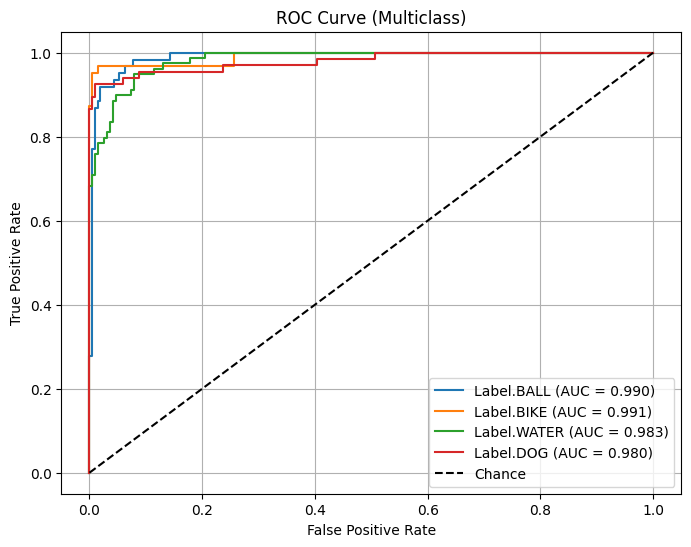

In [138]:
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



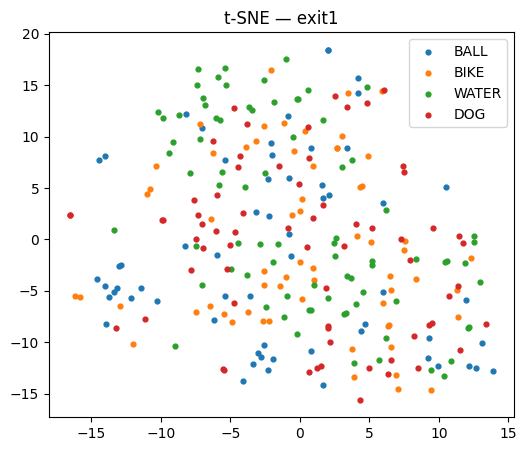

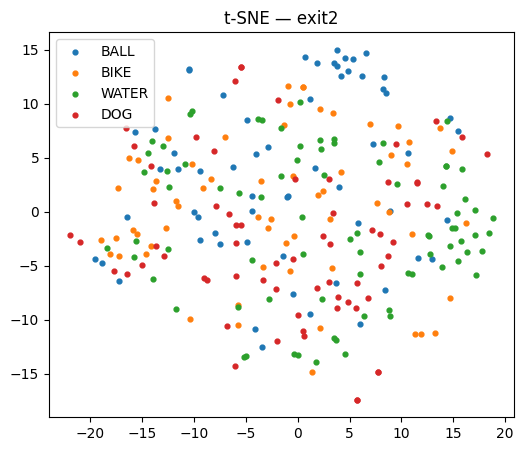

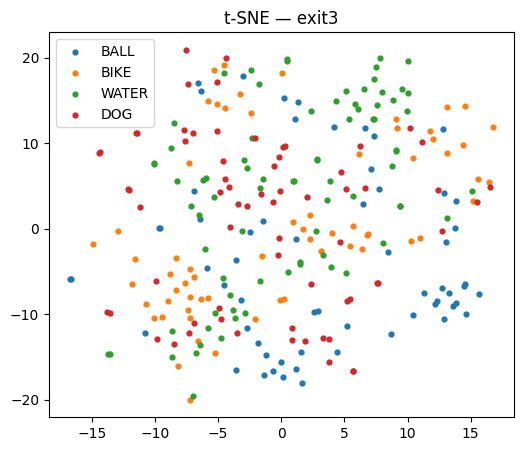

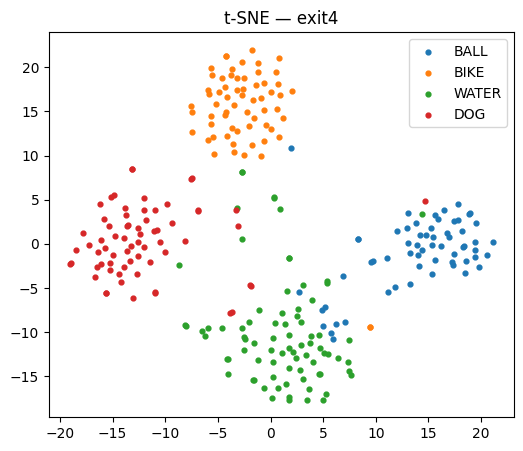

In [139]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(model, loader, class_names, max_samples=500):
    model.eval()
    feats = { "exit1": [], "exit2": [], "exit3": [], "exit4": [] }
    labels = []

    with torch.no_grad():
        for _, (idx, imgs, y) in enumerate(loader):
            imgs = imgs.to(device)

            features = model.extract_features(imgs)
            for k in feats.keys():
                feats[k].append(features[k].cpu().numpy())

            labels.append(y.numpy())
            if len(labels) * imgs.size(0) > max_samples:
                break

    for k in feats.keys():
        X = np.concatenate(feats[k], axis=0)
        Y = np.concatenate(labels, axis=0)

        X_2d = TSNE(n_components=2, learning_rate="auto", init="pca").fit_transform(X)

        plt.figure(figsize=(6,5))
        for i, class_name in enumerate(class_names):
            pts = X_2d[Y == i]
            plt.scatter(pts[:,0], pts[:,1], s=12, label=class_name)

        plt.title(f"t-SNE — {k}")
        plt.legend()
        plt.show()

class_names = ["BALL", "BIKE", "WATER", "DOG"]
plot_tsne(model_resnet_custom, val_loader, class_names)
